In [1]:
import cv2
import os
import numpy as np
from docopt import docopt
import matplotlib.pyplot as plt

In [2]:
class ObjectDetector:
    def __init__(self):
        self.sift = cv2.xfeatures2d.SIFT_create()
        self.FLANN_INDEX_KDTREE = 0
        self.index_params = dict(algorithm=self.FLANN_INDEX_KDTREE, trees=5)
        self.search_params = dict(checks=50)
        

    def detect_object(self,target, ref,Imagebase, result):
        # Find SIFT descriptors for both base and object images
        sift = cv2.xfeatures2d.SIFT_create()
        keypts_base, descr_base = self.sift.detectAndCompute(Imagebase, None)

        keypts_obj, descr_obj = self.sift.detectAndCompute(ref["image"], None)

        flann = cv2.FlannBasedMatcher(self.index_params,self.search_params)
        matches = flann.knnMatch(descr_obj, descr_base, k=2)

        # matches = cv2.BFMatcher().knnMatch(descr_obj, descr_base, k=2)
        matches = [ [i] for i, j in matches if i.distance < 0.75*j.distance]
    #     print(ref["name"])
        if len(matches) > 30:
            src_pts = np.float32([ keypts_obj[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
            dst_pts = np.float32([ keypts_base[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            h, w, d = ref["image"].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = np.int32(cv2.perspectiveTransform(pts, M))

            matching_top_point = tuple(dst[np.argmin([x[0][1] for x in dst])][0])
            result = cv2.polylines(result, [dst], True, (100,250,200), 1, cv2.LINE_AA)
            cv2.putText(result, ref["name"], matching_top_point, cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.7, (255,255,255), 1)
        else:
            print("Could not find any satisfying matches for {}".format(ref["name"]))
            return False

        matching_img = cv2.drawMatchesKnn(ref["image"], keypts_obj, Imagebase, keypts_base, matches, None, flags=2)

        plt.imshow(matching_img)
    #     plt.title('Feature matching for {}'.format(obj))
        plt.axis('off')  # Hide axes
        plt.show()
        return True
    def name_insert(self,target, refs):    
        result = target["image"].copy()
        name_insert = []
        for ref in refs:
            if self.detect_object(target, ref, Imagebase, result) == True:
                 name_insert.append(ref["name"])

        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.imshow(result_rgb)
        plt.title('Final result for {} (refs found: {})'.format(target["name"], ", ".join(name_insert)))
        plt.axis('off')  # Hide axes
        plt.show()





Enter the number of images you want to use:
2
Enter the image name
Enter the objects 1 image:
airpods1.jpg
Enter the objects 2 image:
control.jpg
Enter the base image:
img_query_1.jpg


[ WARN:0@154.075] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


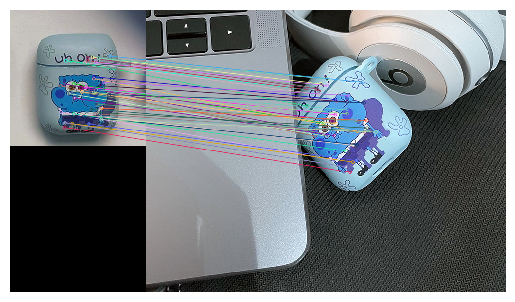

Could not find any satisfying matches for control


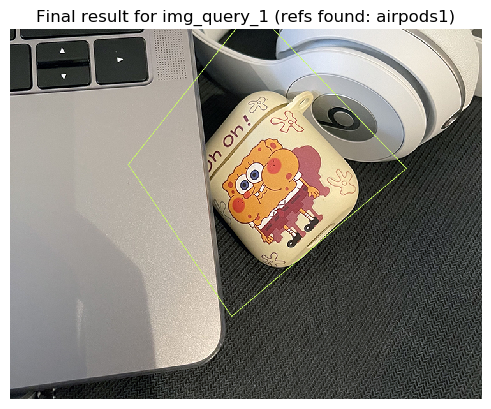

In [4]:
if __name__ == "__main__":
    print("Enter the number of images you want to use:")
    no_of_images = int(input())
    print("Enter the image name")
    
    fileobject = []
    for i in range(no_of_images):
        print("Enter the objects %d image:" %(i+1))
        fileobject.append(input())

    images_objects = []
    for i in range(no_of_images):
        images_objects.append(cv2.imread(fileobject[i]))


    print("Enter the base image:")
    filename_ref = input()
    image_base = cv2.imread(filename_ref)
# img_query_1.jpg

    split=[i.split('.')[0] for i in fileobject]

    Imagebase=cv2.imread(filename_ref)

    filename_object=[cv2.imread(file) for file in fileobject]
    target  = {"name": filename_ref.split('.')[0],"image":Imagebase}
    refs = [{"name": name ,"image": cv2.imread(file)} for name, file in zip(split, fileobject)] 

#     print(objects)
    detector = ObjectDetector()
    detector.name_insert(target, refs)